## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [13]:
data['date']=pd.to_datetime(data['date'])
display(data['date'].min(), data['date'].max())

Timestamp('2021-01-02 00:00:00')

Timestamp('2021-01-24 00:00:00')

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [17]:
data.groupby('group').agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})

,user_id,purchase,price
group,,,
A,147202,17723,1436260000
B,147276,17514,1554100000


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [31]:
user_intersection=set (data[data['group']=='A']['user_id']) & set(data[data['group']=='B']['user_id'])
len(user_intersection)

1895

## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [65]:
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

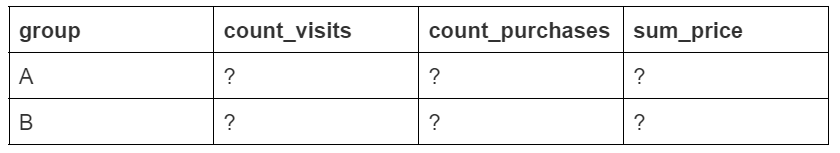
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [135]:
group_df=updated_data.groupby('group', as_index=False).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})
group_df

,group,user_id,purchase,price
0,A,145307,17487,1417780000
1,B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

При первоначальном взгляде на полученные данные складывается ощущение, что показатели варианта B успешнее в части ср. чека. Разница в кол-ве пользователей по группам незначительна. 
Отметим, что при учете того, что общая выручка в варианте B выше, кол-во операций при этом ниже чем в группе A

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [136]:
group_df['conversion']=group_df['purchase']/group_df['user_id']*100
group_df['mean_check']=group_df['price']/group_df['purchase']
group_df

,group,user_id,purchase,price,conversion,mean_check
0,A,145307,17487,1417780000,12.034520,81076.228055
1,B,145381,17290,1533010000,11.892888,88664.545980


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

В группе B мы получили значение ср. чека выше, чем в группе A, но при этом в группе А наблюдается большая конверсия в покупку

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

In [145]:
group_price=updated_data.groupby(['group', 'price'], as_index=False).agg({ 'purchase':'sum'})
group_price

,group,price,purchase
0,A,0,0
1,A,10000,5182
2,A,60000,5271
3,A,100000,1832
4,A,150000,3478
5,A,200000,1724
6,B,0,0
7,B,10000,5201
8,B,60000,1730
9,B,100000,5227


In [197]:
pivot=pd.pivot_table(data=updated_data[updated_data['price']!=0], columns='group', index='price', aggfunc='sum',values='purchase')
pivot

group,A,B
price,,
10000,5182,5201
60000,5271,1730
100000,1832,5227
150000,3478,3438
200000,1724,1694


Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

Text(0.5, 1.0, 'Распределение продаж туров по ценовым сегментам')

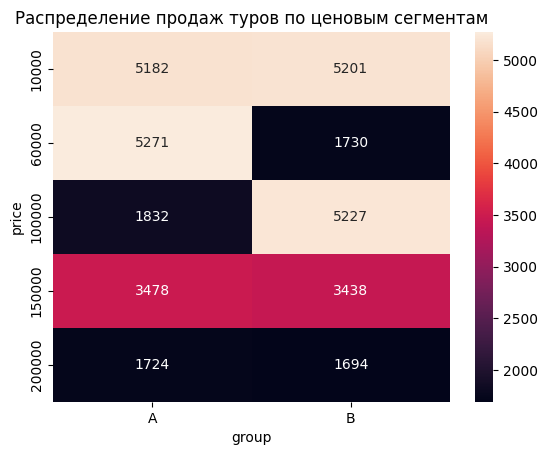

In [233]:
import seaborn as sns
sns.heatmap(pivot, annot=True, fmt=".0f").set_title('Распределение продаж туров по ценовым сегментам')

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

  Я бы выделила в наших турах следующие кластеры:
  - теплые страны (ср. ценовой сегмент)
  - теплые страны (высокий ценовой сегмент)
  - в рамках страны (низкий ценой сегмент)
  - в рамках страны (высокий ценовой сегмент)

  Можно сказать, что в сегменте теплых стран (ср. цены) произошло перераспределние объемов продаж между турами в Турцию и Тайланд. В группе B значительно снизилось кол-во проданных туров в Турцию, но увеличисось кол-во туров в Тайланд. Вероятно, в новом дизайне сайта для группы В ярче описываются достоинства туров в Тайланд
  И за счет того, что туры в Тайланд дороже чем в Турцию, мы получили увеличение общей выручки в группе В

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [252]:
from datetime import datetime
group_day=updated_data.groupby(['group','date'], as_index=False).agg({'user_id':'count', 'purchase':'sum', 'price':'sum'})
group_day['conversion']=group_day['purchase']/group_day['user_id']*100
group_day['mean_check']=group_day['price']/group_day['purchase']
group_day[group_day['date']==datetime(2021, 1, 3)]

,group,date,user_id,purchase,price,conversion,mean_check
1,A,2021-01-03,6596,748,62000000,11.340206,82887.700535
24,B,2021-01-03,6619,754,65960000,11.391449,87480.106101


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [263]:
group_day['count_visits_cum']=group_day.groupby('group')['user_id'].cumsum()
group_day['count_purchases_cum']=group_day.groupby('group')['purchase'].cumsum()
group_day['sum_price']=group_day.groupby('group')['price'].cumsum()
group_day['conversion_cum']=group_day['count_purchases_cum']/group_day['count_visits_cum']*100
group_day['mean_check_cum']=group_day['sum_price']/group_day['count_purchases_cum']
group_day[group_day['date']==datetime(2021, 1, 20)]

,group,date,user_id,purchase,price,conversion,mean_check,count_visits_cum,count_purchases_cum,sum_pric,sum_price,conversion_cum,mean_check_cum
18,A,2021-01-20,6533,749,58710000,11.464871,78384.512684,121506,14561,1179590000,1179590000,11.983770,81010.232814
41,B,2021-01-20,6685,790,69250000,11.817502,87658.227848,121857,14496,1286900000,1286900000,11.895911,88776.214128


In [268]:
group_day[group_day['date']==datetime(2021, 1, 12)]

,group,date,user_id,purchase,price,conversion,mean_check,count_visits_cum,count_purchases_cum,sum_pric,sum_price,conversion_cum,mean_check_cum
10,A,2021-01-12,6540,795,68460000,12.155963,86113.207547,68852,8198,668070000,668070000,11.906698,81491.827275
33,B,2021-01-12,6635,807,70560000,12.162773,87434.944238,69251,8236,727670000,727670000,11.892969,88352.355512


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

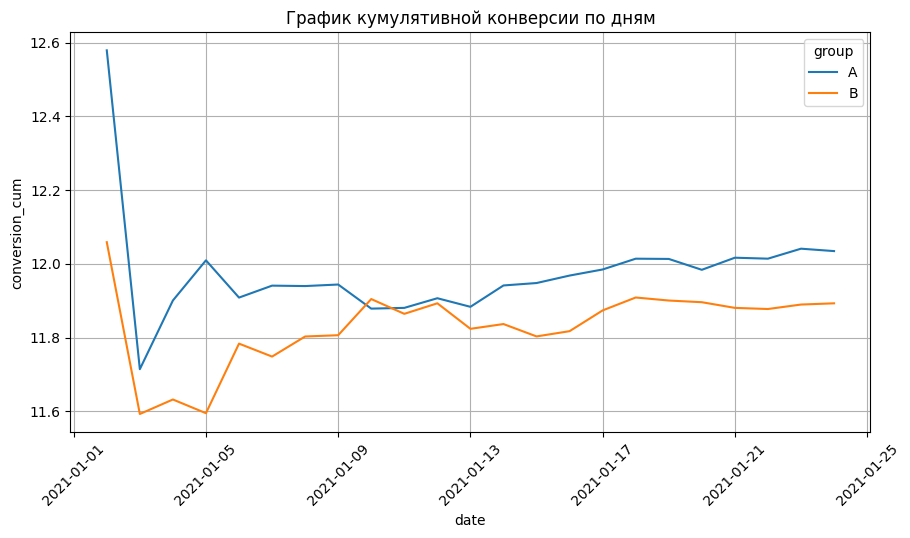

In [277]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='conversion_cum', data=group_day, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

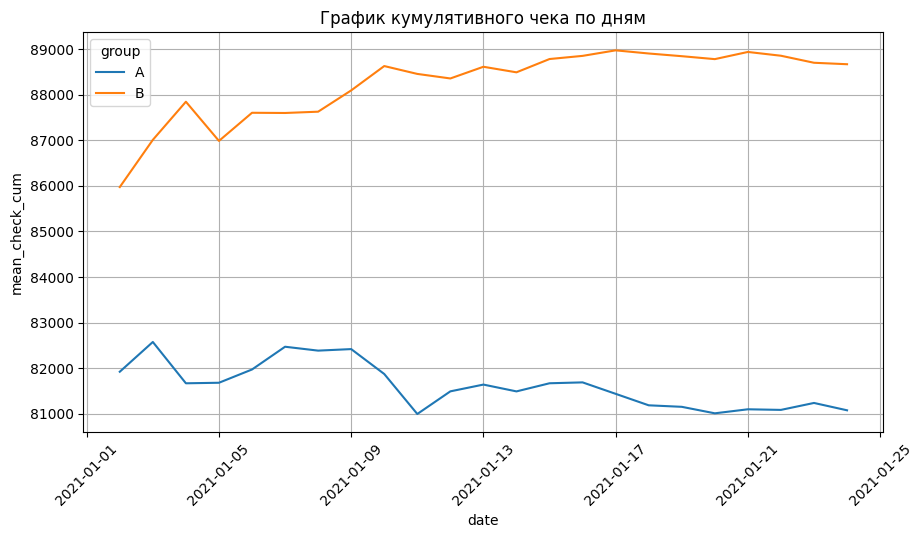

In [278]:
# создаём фигуру размером 8x4
fig = plt.figure(figsize=(8, 4))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для кумулятивной конверсии во времени в каждой группе
sns.lineplot(x='date', y='mean_check_cum', data=group_day, hue='group', ax=ax)
# задаём подпись к графику
ax.set_title('График кумулятивного чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation = 45)
# задаём отображение сетки
ax.grid(True);

Кумулятивные показатели среднего чека и конверсии стабилизировались. Конверсия с 12 января стабильно выше в группе А, средний же чек с самого начала наблюдений за группами показывает более высокие показатели в группе В

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

In [294]:
# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B статистически значимо не отличаются'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости
# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=group_df['purchase'], #число "успехов"
    nobs=group_df['user_id'], #общее число наблюдений
    alternative='larger',
)
# выводим результат на экран
print('p-value: ', round(p_value, 2))
# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Не отвергаем нулевую гипотезу. {}".format(H0))

p-value:  0.12
Не отвергаем нулевую гипотезу. Конверсии в группах А и B статистически значимо не отличаются


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

Статичстически значимых различий в имеющихся наблюдениях конверсии в покупку не зафиксировано. Нельзя утверждать, что в группе А конверсия выше

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [353]:
#фильтруем данные группы А
a_data = group_df[group_df['group'] == 'A']
#фильтруем данные группы B
b_data = group_df[group_df['group'] == 'B']

In [354]:
def proportions_conf_interval(n, x_p, gamma=0.95):   
    alpha = 1 - gamma # уровень значимости
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5 #погрешность
    lower_bound = x_p - eps # левая (нижняя) граница
    upper_bound = x_p + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [355]:
conf_interval_a = proportions_conf_interval(
n=a_data['user_id'].sum(), # размер выборки
x_p=a_data['conversion'].sum()/100 # выборочная пропорция
)
conf_interval_b = proportions_conf_interval(
n=b_data['user_id'].sum(), # размер выборки
x_p=b_data['conversion'].sum()/100 # выборочная пропорция
)
print('Доверительный интервал для конверсии группы А: {}'.format(conf_interval_a))
print('Доверительный интервал для конверсии группы B: {}'.format(conf_interval_b))

Доверительный интервал для конверсии группы А: (11.87, 12.2)
Доверительный интервал для конверсии группы B: (11.73, 12.06)


In [356]:
def diff_proportions_conf_interval(n, xp, gamma=0.95):
    alpha = 1 - gamma # уровень значимости
    diff = xp[1] - xp[0] # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha/2) # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0])/n[0] + xp[1] * (1 - xp[1])/n[1]) ** 0.5 # погрешность
    lower_bound = diff - eps # левая (нижняя) граница
    upper_bound = diff + eps # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return lower_bound *100, upper_bound * 100

In [357]:
# размеры выборок групп А и B
n = [a_data['user_id'].sum(), b_data['user_id'].sum()]
# выборочная пропорция групп A и B
xp = [a_data['conversion'].sum()/100, b_data['conversion'].sum()/100]
# строим доверительный интервал для разности конверсий
diff_inverval = diff_proportions_conf_interval(n, xp)
print('Доверительный интервал для разности конверсий: {}'.format(diff_inverval))

Доверительный интервал для разности конверсий: (-0.37758576531742105, 0.09432241616998205)


Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Варинаты A и В равнозначны по конверсии, т.к. доверительный интервал разности конверсий включает в себя как отрицательные значения, так и положительные, статичтискески значимых различий зафиксировать не удалось

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

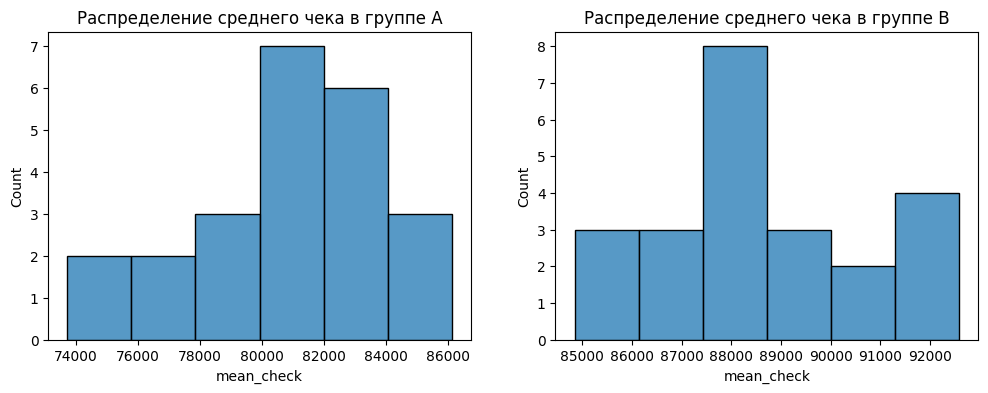

In [360]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
#строим гистограмму для времени на сайте в каждой группе
sns.histplot(x='mean_check', data=group_day[group_day['group'] == 'A'], ax=axes[0])
sns.histplot(x='mean_check', data=group_day[group_day['group'] == 'B'], ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение среднего чека в группе А');
axes[1].set_title('Распределение среднего чека в группе B');

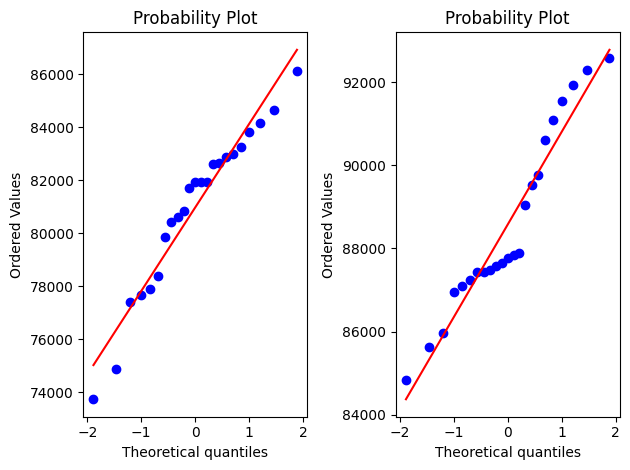

In [366]:
import matplotlib.pyplot as plt # библиотека визуализации
from scipy import stats # библиотека для расчетов

plt.subplot(1, 2, 1) # задаем сетку рисунка количество строк и столбцов
stats.probplot(group_day[group_day['group'] == 'A']['mean_check'], plot=plt) # qq plot

plt.subplot(1, 2, 2) # располагаем второй рисунок рядом
stats.probplot(group_day[group_day['group'] == 'B']['mean_check'], plot=plt) # qq plot

plt.tight_layout() # чтобы графики не наезжали другу на друга, используем tight_layout

plt.show() # просмотр графика

In [372]:
from scipy.stats import shapiro
# нулевая и альтернативная гипотезы
H0 = 'Распределения в обеих группах нормальные'
H1 = 'Распределение в одной или обеих группах отлично от нормального'
alpha = 0.05 # уровень значимости
# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(group_day[group_day['group'] == 'A']['mean_check'])
shapiro_result_b = shapiro(group_day[group_day['group'] == 'B']['mean_check'])
print('p-value группы А', round(shapiro_result_a.pvalue, 2))
print('p-value группы B', round(shapiro_result_b.pvalue, 2))
# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. {}".format(H0))
    print("Альтернативная гипотеза. H1: {}".format(H1))
else:
    print("Не отвергаем нулевую гипотезу. {}".format(H0))

p-value группы А 0.25
p-value группы B 0.09
Не отвергаем нулевую гипотезу. Распределения в обеих группах нормальные


На графиках QQ-plot мы видим, что распределение наблюдений легли достаточно близко к нормальному распределению
Расчет с помощью теста Шапиро-Уилка говорит о том, что распределения среднего чека в обеих группах монжно отнести к нормальному

## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [387]:
from scipy.stats import ttest_ind
results=ttest_ind(group_day[group_day['group'] == 'A']['mean_check'],group_day[group_day['group'] == 'B']['mean_check'], alternative='less')
round(results[1],2)

0.0

 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

p-value < заданного уровня значимости, что позволяет нам отклонить нулевую гипотезу и говорить о том, что ср. чек в группе B статистически значимо выше, чем в группе А

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [393]:
from scipy.stats import t
def interval(n, x_mean, x_std, alpha=0.05): 
    k = n - 1
    t_crit = -t.ppf(alpha/2, k) # t-критическое
    eps = t_crit * x_std/(n ** 0.5) # погрешность
    lower_bound = x_mean - eps # левая (нижняя) граница
    upper_bound = x_mean + eps # правая (верхняя) граница
    confidence_interval = (round(lower_bound), round(upper_bound)) # создаём кортеж из округлённых границ интервала
    print('Доверительный интервал: {}'.format(confidence_interval)) # выводим результат

group_a=group_day[group_day['group'] == 'A']
group_b=group_day[group_day['group'] == 'B']
interval(group_a['user_id'].count(), group_a['mean_check'].mean(),  group_a['mean_check'].std())
interval(group_b['user_id'].count(), group_b['mean_check'].mean(),  group_b['mean_check'].std())

Доверительный интервал: (79630, 82308)
Доверительный интервал: (87626, 89526)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительный интервал группы B выше, пересечений между доверительными интервалами групп А и B нет

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

Так как при проверке конверсии мы не зафикисировали статистически значимых различий между группами А и B, но при этом ср. чеку стат. значимо выше в группе B, то можно рекомендовать в дальнейшей работе использовать дизайн сайта, который отображали для группы B